In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

import orc
import orc.utils.visualization as vis

jax.config.update("jax_enable_x64", True)

# Integrate some KS data

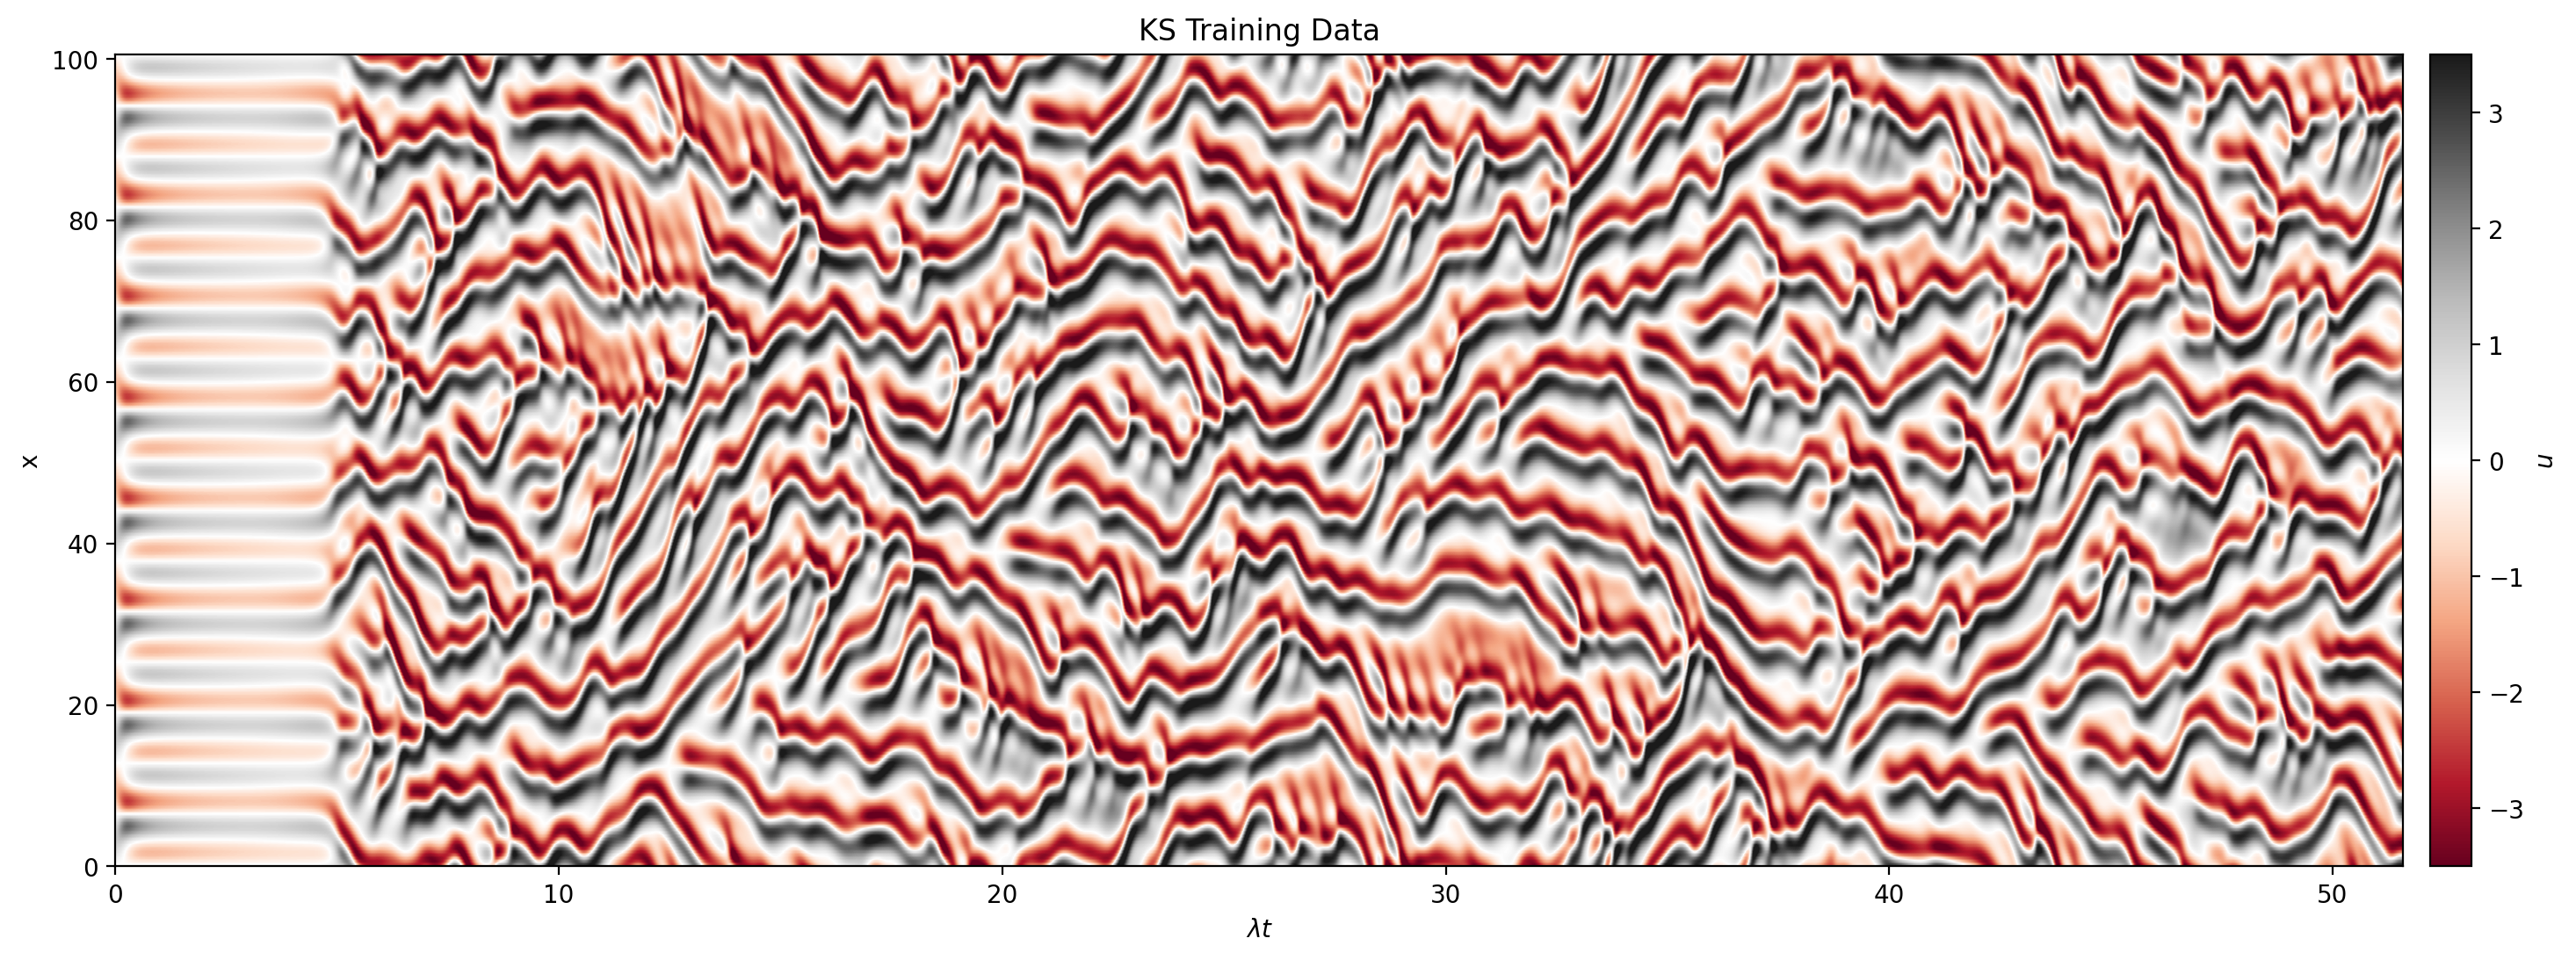

In [2]:
# integrate
Nx = 256
tN = 1500
domain = (0, 32 * jnp.pi)
lyap = 0.043
x0 = jnp.linspace(domain[0], domain[1], Nx, endpoint=True)  # Note: important to ensure PBC of IC. (however, the spectral solver throws away this point)
u0 = jnp.sin((16 / domain[1]) * jnp.pi * x0)
dt = 0.1
U,t = orc.data.KS_1D(tN, u0=u0, dt=dt, domain=domain, Nx=Nx)

# train test split
test_perc = 0.2
split_index = int((1 - test_perc) * U.shape[0])
U_train = U[:split_index, :]
U_test = U[split_index:, :]
t_train = t[:split_index] * lyap
t_test = jnp.linspace(0, U_test.shape[1]*dt, U_test.shape[1]) * lyap

# visualize training data
vis.imshow_1D_spatiotemp(
    U_train,
    t_train[-1],
    domain,
    vmax=3.5,
    vmin=-3.5,
    title="KS Training Data",
    x_label= r"$\lambda t$",
)

In [3]:
# esn parameters
res_dim = 1000 # number of reservoir neurons per chunk
chunks = 32  # number of chunks
locality = 6  # locality parameter for reservoir connections
quadratic = True  # whether to use quadratic readout 

# init esn
esn = orc.models.ESNForecaster(data_dim=Nx,
                               res_dim=res_dim,
                               seed=2,
                               chunks=chunks,
                               locality=locality,
                               quadratic=quadratic)

# train esn 
esn, R = orc.models.esn.train_ESNForecaster(
    esn,
    U_train,
    spinup=200,
    initial_res_state=jax.numpy.zeros((chunks, res_dim), dtype=jnp.float64),
    beta=8e-8,
)

# forecast
U_fcast = esn.forecast(U_test.shape[0], R[-1])

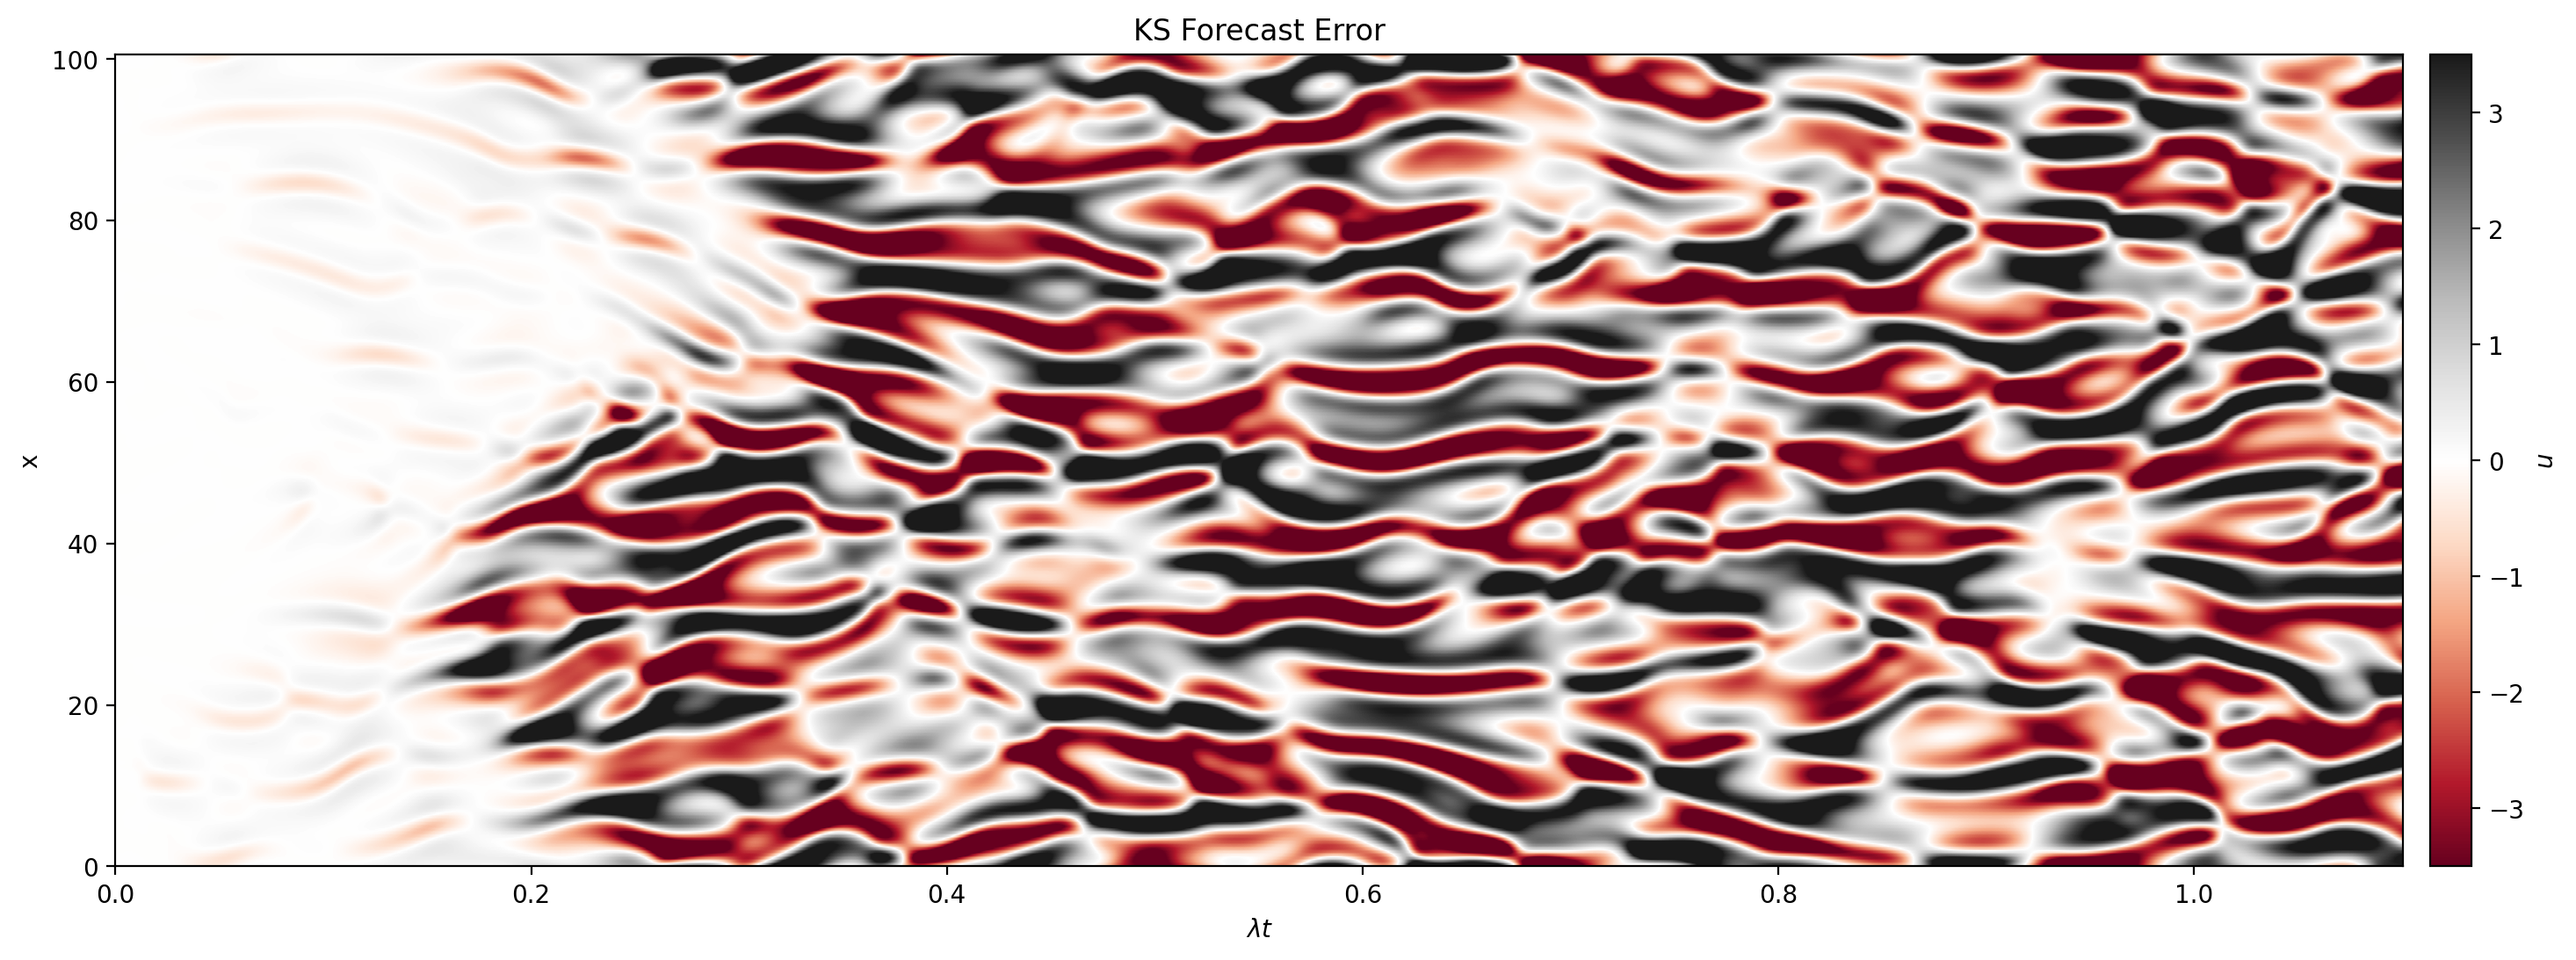

In [4]:
# imshow_1D_spatiotemp(fcast.T - U_test.T, test_perc * TN, domain, vmax=3.5, vmin=-3.5)
vis.imshow_1D_spatiotemp(
    U_fcast - U_test,
    t_test[-1],
    domain,
    vmax=3.5,
    vmin=-3.5,
    title="KS Forecast Error",
    x_label= r"$\lambda t$",
)